### Audio Load by Barney

In [1]:
from barney_functions import *
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import soundfile as sf
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [39]:
X_train = np.load('mels_BAD_PROPER_train.npz')['data']
y_train = np.load('mels_lables_BAD_PROPER_train.npz',allow_pickle=True)['data']
X_val = np.load('mels_BAD_PROPER_val.npz')['data']
y_val = np.load('mels_lables_BAD_PROPER_val.npz',allow_pickle=True)['data']
X_test = np.load('mels_BAD_PROPER_test.npz')['data']
y_test = np.load('mels_lables_BAD_PROPER_test.npz',allow_pickle=True)['data']
num_classes = len(np.unique(y_train))
classes = np.unique(y_train)

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
check_class_complete_gen(y_test, y_val,y_train)
np.unique(y_train)

(7016, 128, 51)
(7016,)
(127, 128, 51)
(127,)
(127, 128, 51)
(127,)
OK


array(['snort', 'squeal'], dtype=object)

# CNN

In [4]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam
from optuna.integration import TFKerasPruningCallback
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/Users/barnabyemmens/opt/anaconda3/envs/appml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.model_selection import KFold

In [6]:
import optuna

In [7]:
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num CPUs Available:  1


# Optimising

In [8]:
def objective(trial):
    n_epochs = trial.suggest_int("n_epochs", low=5, high=50, step=5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3)
    optimiser = Adam(learning_rate=learning_rate)
    
    filters_1 = trial.suggest_int("filters_1",low=2,high=32,step=2)
    kernel_1 = trial.suggest_int("kernel_size_1",low=8,high=16,step=4)
    strides_1 = 1
    padding_1 = 'same'
    activation_1 = 'relu'
    input_shape = (img_rows, img_cols, 1)
    pool_size_1 = trial.suggest_int("pool_size_1",low=2,high=4,step=1)
    
    filters_2 = trial.suggest_int("filters_2",low=2,high=64,step=2)
    kernel_2 = trial.suggest_int("kernel_size_2",low=4,high=12,step=2)
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = 'relu'
    pool_size_2 = trial.suggest_int("pool_size_2",low=2,high=4,step=1)
    
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.9)
    
    lin_1_n = trial.suggest_int("lin_1_n",low=4,high=128,step=1)
    
    batch_size = trial.suggest_int("batch_size",low=64,high=512,step=64)
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    monitor = "val_categorical_accuracy"
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5),
        TFKerasPruningCallback(trial, monitor)]
    
    fitted = model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=n_epochs,
                       verbose=1,
                       validation_data=(X_val, y_val),
                       callbacks=callbacks)
    
    score = fitted.history[monitor][-1]
    
    return score

In [41]:
X_train, X_val, y_train, y_val, img_rows, img_cols = format_for_CNN(X_train, X_val, y_train, y_val)
check_class_complete_gen(y_train, y_val,y_train)

OK


In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(7016, 128, 51, 1)
(7016, 2)
(127, 128, 51, 1)
(127, 2)


In [ ]:
study = optuna.create_study(direction='maximize')

In [11]:
study.optimize(objective, n_trials=50)

[I 2022-06-14 01:08:57,956] A new study created in memory with name: no-name-9bfd3d1c-a60e-4f6b-af64-d65de1d9a7bd
2022-06-14 01:08:57.964741: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
28/28 [==============================] - 34s 1s/step - loss: 0.6030 - categorical_accuracy: 0.6622 - val_loss: 0.6467 - val_categorical_accuracy: 0.6299
Epoch 2/25
28/28 [==============================] - 33s 1s/step - loss: 0.4801 - categorical_accuracy: 0.7678 - val_loss: 0.5815 - val_categorical_accuracy: 0.6929
Epoch 3/25
28/28 [==============================] - 33s 1s/step - loss: 0.4155 - categorical_accuracy: 0.8059 - val_loss: 0.4937 - val_categorical_accuracy: 0.7638
Epoch 4/25
28/28 [==============================] - 32s 1s/step - loss: 0.3631 - categorical_accuracy: 0.8421 - val_loss: 0.4224 - val_categorical_accuracy: 0.8031
Epoch 5/25
28/28 [==============================] - 32s 1s/step - loss: 0.3136 - categorical_accuracy: 0.8709 - val_loss: 0.3480 - val_categorical_accuracy: 0.8583
Epoch 6/25
28/28 [==============================] - 32s 1s/step - loss: 0.2776 - categorical_accuracy: 0.8868 - val_loss: 0.4075 - val_categorical_accuracy: 0.8189
Epoch 7/25
28/28

[I 2022-06-14 01:21:57,495] Trial 0 finished with value: 0.9291338324546814 and parameters: {'n_epochs': 25, 'learning_rate': 0.0002770067725670508, 'filters_1': 26, 'kernel_size_1': 12, 'pool_size_1': 2, 'filters_2': 32, 'kernel_size_2': 4, 'pool_size_2': 4, 'dropout_rate': 0.27535446208846337, 'lin_1_n': 25, 'batch_size': 256}. Best is trial 0 with value: 0.9291338324546814.


Epoch 1/50
14/14 [==============================] - 26s 2s/step - loss: 0.6893 - categorical_accuracy: 0.5496 - val_loss: 0.7016 - val_categorical_accuracy: 0.4646
Epoch 2/50
14/14 [==============================] - 25s 2s/step - loss: 0.6515 - categorical_accuracy: 0.6169 - val_loss: 0.7272 - val_categorical_accuracy: 0.4016
Epoch 3/50
14/14 [==============================] - 27s 2s/step - loss: 0.6151 - categorical_accuracy: 0.6531 - val_loss: 0.7004 - val_categorical_accuracy: 0.5276
Epoch 4/50
14/14 [==============================] - 28s 2s/step - loss: 0.5747 - categorical_accuracy: 0.6900 - val_loss: 0.7645 - val_categorical_accuracy: 0.4803
Epoch 5/50
14/14 [==============================] - 28s 2s/step - loss: 0.5464 - categorical_accuracy: 0.7166 - val_loss: 0.8215 - val_categorical_accuracy: 0.4567
Epoch 6/50
14/14 [==============================] - 28s 2s/step - loss: 0.5291 - categorical_accuracy: 0.7242 - val_loss: 0.7535 - val_categorical_accuracy: 0.5433
Epoch 7/50
14/14

[I 2022-06-14 01:25:35,782] Trial 1 finished with value: 0.5826771855354309 and parameters: {'n_epochs': 50, 'learning_rate': 0.0002642396415404626, 'filters_1': 16, 'kernel_size_1': 8, 'pool_size_1': 2, 'filters_2': 12, 'kernel_size_2': 8, 'pool_size_2': 4, 'dropout_rate': 0.776992331143332, 'lin_1_n': 101, 'batch_size': 512}. Best is trial 0 with value: 0.9291338324546814.


Epoch 1/25
19/19 [==============================] - 71s 4s/step - loss: 0.7344 - categorical_accuracy: 0.4902 - val_loss: 0.6940 - val_categorical_accuracy: 0.0315
Epoch 2/25
19/19 [==============================] - 67s 4s/step - loss: 0.6932 - categorical_accuracy: 0.4835 - val_loss: 0.6932 - val_categorical_accuracy: 0.0315
Epoch 3/25
19/19 [==============================] - 68s 4s/step - loss: 0.6931 - categorical_accuracy: 0.5148 - val_loss: 0.6920 - val_categorical_accuracy: 0.9685
Epoch 4/25
19/19 [==============================] - 68s 4s/step - loss: 0.6931 - categorical_accuracy: 0.5165 - val_loss: 0.6903 - val_categorical_accuracy: 0.9685
Epoch 5/25
19/19 [==============================] - 68s 4s/step - loss: 0.6930 - categorical_accuracy: 0.5165 - val_loss: 0.6886 - val_categorical_accuracy: 0.9685
Epoch 6/25
19/19 [==============================] - 67s 4s/step - loss: 0.6930 - categorical_accuracy: 0.5165 - val_loss: 0.6870 - val_categorical_accuracy: 0.9685
Epoch 7/25
19/19

[I 2022-06-14 01:54:00,672] Trial 2 finished with value: 0.9685039520263672 and parameters: {'n_epochs': 25, 'learning_rate': 0.00034985316824705817, 'filters_1': 18, 'kernel_size_1': 16, 'pool_size_1': 2, 'filters_2': 42, 'kernel_size_2': 8, 'pool_size_2': 2, 'dropout_rate': 0.1548662937236178, 'lin_1_n': 31, 'batch_size': 384}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/15
110/110 [==============================] - 48s 432ms/step - loss: 0.4682 - categorical_accuracy: 0.7614 - val_loss: 0.3953 - val_categorical_accuracy: 0.8110
Epoch 2/15
110/110 [==============================] - 46s 422ms/step - loss: 0.2545 - categorical_accuracy: 0.8967 - val_loss: 0.2906 - val_categorical_accuracy: 0.8504
Epoch 3/15
110/110 [==============================] - 47s 426ms/step - loss: 0.1502 - categorical_accuracy: 0.9421 - val_loss: 0.3500 - val_categorical_accuracy: 0.8268
Epoch 4/15
110/110 [==============================] - 48s 435ms/step - loss: 0.1141 - categorical_accuracy: 0.9554 - val_loss: 0.3491 - val_categorical_accuracy: 0.8346
Epoch 5/15
110/110 [==============================] - 51s 461ms/step - loss: 0.0874 - categorical_accuracy: 0.9658 - val_loss: 0.1599 - val_categorical_accuracy: 0.9291
Epoch 6/15
110/110 [==============================] - 48s 438ms/step - loss: 0.0684 - categorical_accuracy: 0.9755 - val_loss: 0.1337 - val_categorical_acc

[I 2022-06-14 02:05:58,949] Trial 3 finished with value: 0.9448819160461426 and parameters: {'n_epochs': 15, 'learning_rate': 0.0009155805887424225, 'filters_1': 26, 'kernel_size_1': 12, 'pool_size_1': 2, 'filters_2': 12, 'kernel_size_2': 8, 'pool_size_2': 2, 'dropout_rate': 0.5704151126606425, 'lin_1_n': 123, 'batch_size': 64}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/45
14/14 [==============================] - 14s 944ms/step - loss: 0.6342 - categorical_accuracy: 0.6452 - val_loss: 0.7121 - val_categorical_accuracy: 0.4882
Epoch 2/45
14/14 [==============================] - 13s 939ms/step - loss: 0.5067 - categorical_accuracy: 0.7547 - val_loss: 0.6949 - val_categorical_accuracy: 0.5276
Epoch 3/45
14/14 [==============================] - 14s 965ms/step - loss: 0.4519 - categorical_accuracy: 0.7821 - val_loss: 0.6591 - val_categorical_accuracy: 0.5591
Epoch 4/45
14/14 [==============================] - 13s 950ms/step - loss: 0.4099 - categorical_accuracy: 0.8107 - val_loss: 0.5379 - val_categorical_accuracy: 0.7244
Epoch 5/45
14/14 [==============================] - 13s 952ms/step - loss: 0.3700 - categorical_accuracy: 0.8351 - val_loss: 0.4715 - val_categorical_accuracy: 0.8031
Epoch 6/45
14/14 [==============================] - 13s 939ms/step - loss: 0.3293 - categorical_accuracy: 0.8610 - val_loss: 0.2892 - val_categorical_accuracy: 0.897

[I 2022-06-14 02:12:38,351] Trial 4 finished with value: 0.960629940032959 and parameters: {'n_epochs': 45, 'learning_rate': 0.0009290841058695773, 'filters_1': 2, 'kernel_size_1': 8, 'pool_size_1': 2, 'filters_2': 10, 'kernel_size_2': 8, 'pool_size_2': 3, 'dropout_rate': 0.16246528787405082, 'lin_1_n': 71, 'batch_size': 512}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/20
14/14 [==============================] - 40s 3s/step - loss: 0.6896 - categorical_accuracy: 0.5586 - val_loss: 0.6163 - val_categorical_accuracy: 0.9370
Epoch 2/20
14/14 [==============================] - 40s 3s/step - loss: 0.6267 - categorical_accuracy: 0.6424 - val_loss: 0.5918 - val_categorical_accuracy: 0.6614
Epoch 3/20
14/14 [==============================] - 42s 3s/step - loss: 0.5611 - categorical_accuracy: 0.6981 - val_loss: 0.5026 - val_categorical_accuracy: 0.7874
Epoch 4/20
14/14 [==============================] - 42s 3s/step - loss: 0.5142 - categorical_accuracy: 0.7349 - val_loss: 0.4960 - val_categorical_accuracy: 0.7402
Epoch 5/20
14/14 [==============================] - 40s 3s/step - loss: 0.4755 - categorical_accuracy: 0.7631 - val_loss: 0.5140 - val_categorical_accuracy: 0.7165
Epoch 6/20
14/14 [==============================] - 40s 3s/step - loss: 0.4356 - categorical_accuracy: 0.7909 - val_loss: 0.4955 - val_categorical_accuracy: 0.7402
Epoch 7/20
14/14

[I 2022-06-14 02:20:39,922] Trial 5 pruned. Trial was pruned at epoch 11.


Epoch 1/45
28/28 [==============================] - 23s 826ms/step - loss: 0.6571 - categorical_accuracy: 0.6060 - val_loss: 0.6498 - val_categorical_accuracy: 0.6220
Epoch 2/45
28/28 [==============================] - 23s 810ms/step - loss: 0.5385 - categorical_accuracy: 0.7281 - val_loss: 0.5702 - val_categorical_accuracy: 0.7323
Epoch 3/45
28/28 [==============================] - 23s 811ms/step - loss: 0.4707 - categorical_accuracy: 0.7695 - val_loss: 0.5163 - val_categorical_accuracy: 0.7953
Epoch 4/45
28/28 [==============================] - 23s 812ms/step - loss: 0.4266 - categorical_accuracy: 0.7942 - val_loss: 0.4817 - val_categorical_accuracy: 0.8110
Epoch 5/45
28/28 [==============================] - 23s 809ms/step - loss: 0.3970 - categorical_accuracy: 0.8187 - val_loss: 0.3781 - val_categorical_accuracy: 0.8976
Epoch 6/45
28/28 [==============================] - 23s 804ms/step - loss: 0.3742 - categorical_accuracy: 0.8291 - val_loss: 0.3632 - val_categorical_accuracy: 0.921

[I 2022-06-14 02:32:09,053] Trial 6 finished with value: 0.9685039520263672 and parameters: {'n_epochs': 45, 'learning_rate': 0.00017052801060260048, 'filters_1': 2, 'kernel_size_1': 12, 'pool_size_1': 3, 'filters_2': 52, 'kernel_size_2': 6, 'pool_size_2': 2, 'dropout_rate': 0.7859492523205107, 'lin_1_n': 93, 'batch_size': 256}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/35
55/55 [==============================] - 53s 949ms/step - loss: 0.6192 - categorical_accuracy: 0.6378 - val_loss: 0.5316 - val_categorical_accuracy: 0.6772
Epoch 2/35
55/55 [==============================] - 51s 936ms/step - loss: 0.4769 - categorical_accuracy: 0.7641 - val_loss: 0.4135 - val_categorical_accuracy: 0.7559
Epoch 3/35
55/55 [==============================] - 52s 945ms/step - loss: 0.3999 - categorical_accuracy: 0.8100 - val_loss: 0.3654 - val_categorical_accuracy: 0.7953
Epoch 4/35
55/55 [==============================] - 52s 949ms/step - loss: 0.3430 - categorical_accuracy: 0.8476 - val_loss: 0.2647 - val_categorical_accuracy: 0.8819
Epoch 5/35
55/55 [==============================] - 52s 943ms/step - loss: 0.2819 - categorical_accuracy: 0.8779 - val_loss: 0.2319 - val_categorical_accuracy: 0.8976
Epoch 6/35
55/55 [==============================] - 51s 935ms/step - loss: 0.2312 - categorical_accuracy: 0.9048 - val_loss: 0.1915 - val_categorical_accuracy: 0.929

[I 2022-06-14 02:46:00,530] Trial 7 finished with value: 0.9370078444480896 and parameters: {'n_epochs': 35, 'learning_rate': 0.0004817655469872558, 'filters_1': 20, 'kernel_size_1': 16, 'pool_size_1': 4, 'filters_2': 12, 'kernel_size_2': 12, 'pool_size_2': 4, 'dropout_rate': 0.7372983159655105, 'lin_1_n': 111, 'batch_size': 128}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/25
22/22 [==============================] - 29s 1s/step - loss: 0.7032 - categorical_accuracy: 0.5527 - val_loss: 0.6170 - val_categorical_accuracy: 0.9528
Epoch 2/25
22/22 [==============================] - 28s 1s/step - loss: 0.6280 - categorical_accuracy: 0.6418 - val_loss: 0.5818 - val_categorical_accuracy: 0.7638
Epoch 3/25
22/22 [==============================] - 27s 1s/step - loss: 0.5683 - categorical_accuracy: 0.6961 - val_loss: 0.5610 - val_categorical_accuracy: 0.7165
Epoch 4/25
22/22 [==============================] - 26s 1s/step - loss: 0.5216 - categorical_accuracy: 0.7392 - val_loss: 0.5300 - val_categorical_accuracy: 0.7402
Epoch 5/25
22/22 [==============================] - 26s 1s/step - loss: 0.4868 - categorical_accuracy: 0.7516 - val_loss: 0.5737 - val_categorical_accuracy: 0.6378
Epoch 6/25
22/22 [==============================] - 27s 1s/step - loss: 0.4573 - categorical_accuracy: 0.7795 - val_loss: 0.5145 - val_categorical_accuracy: 0.7480
Epoch 7/25
22/22

[I 2022-06-14 02:50:58,250] Trial 8 pruned. Trial was pruned at epoch 10.


Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 0.5781 - categorical_accuracy: 0.6827

[I 2022-06-14 02:51:39,476] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/5
19/19 [==============================] - 59s 3s/step - loss: 0.6806 - categorical_accuracy: 0.5432 - val_loss: 0.6335 - val_categorical_accuracy: 0.9213
Epoch 2/5
19/19 [==============================] - 59s 3s/step - loss: 0.6533 - categorical_accuracy: 0.6300 - val_loss: 0.6253 - val_categorical_accuracy: 0.7795
Epoch 3/5
19/19 [==============================] - 58s 3s/step - loss: 0.6253 - categorical_accuracy: 0.6648 - val_loss: 0.6318 - val_categorical_accuracy: 0.7165
Epoch 4/5
19/19 [==============================] - 58s 3s/step - loss: 0.5953 - categorical_accuracy: 0.6936 - val_loss: 0.6104 - val_categorical_accuracy: 0.7165
Epoch 5/5
19/19 [==============================] - 59s 3s/step - loss: 0.5699 - categorical_accuracy: 0.7020 - val_loss: 0.6509 - val_categorical_accuracy: 0.5906


[I 2022-06-14 02:56:32,930] Trial 10 finished with value: 0.5905511975288391 and parameters: {'n_epochs': 5, 'learning_rate': 2.8629535258241118e-05, 'filters_1': 14, 'kernel_size_1': 16, 'pool_size_1': 3, 'filters_2': 40, 'kernel_size_2': 10, 'pool_size_2': 2, 'dropout_rate': 0.12497751325140524, 'lin_1_n': 4, 'batch_size': 384}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/35
37/37 [==============================] - 25s 671ms/step - loss: 0.6865 - categorical_accuracy: 0.5475 - val_loss: 0.6325 - val_categorical_accuracy: 0.9606
Epoch 2/35
37/37 [==============================] - 25s 671ms/step - loss: 0.6547 - categorical_accuracy: 0.6204 - val_loss: 0.6245 - val_categorical_accuracy: 0.8031
Epoch 3/35
37/37 [==============================] - 25s 671ms/step - loss: 0.6186 - categorical_accuracy: 0.6561 - val_loss: 0.6400 - val_categorical_accuracy: 0.6299
Epoch 4/35
37/37 [==============================] - 25s 668ms/step - loss: 0.5768 - categorical_accuracy: 0.6958 - val_loss: 0.6837 - val_categorical_accuracy: 0.5512
Epoch 5/35
37/37 [==============================] - 25s 672ms/step - loss: 0.5396 - categorical_accuracy: 0.7255 - val_loss: 0.5995 - val_categorical_accuracy: 0.6772
Epoch 6/35
37/37 [==============================] - 26s 689ms/step - loss: 0.5094 - categorical_accuracy: 0.7524 - val_loss: 0.6338 - val_categorical_accuracy: 0.606

[I 2022-06-14 03:03:43,623] Trial 11 pruned. Trial was pruned at epoch 16.


Epoch 1/10
19/19 [==============================] - 26s 1s/step - loss: 0.6535 - categorical_accuracy: 0.6083 - val_loss: 0.5687 - val_categorical_accuracy: 0.7244
Epoch 2/10
19/19 [==============================] - 26s 1s/step - loss: 0.5001 - categorical_accuracy: 0.7429 - val_loss: 0.7202 - val_categorical_accuracy: 0.5512
Epoch 3/10
19/19 [==============================] - 26s 1s/step - loss: 0.4317 - categorical_accuracy: 0.7901 - val_loss: 0.4299 - val_categorical_accuracy: 0.7795
Epoch 4/10
19/19 [==============================] - 26s 1s/step - loss: 0.3592 - categorical_accuracy: 0.8432 - val_loss: 0.3458 - val_categorical_accuracy: 0.8425
Epoch 5/10
19/19 [==============================] - ETA: 0s - loss: 0.2963 - categorical_accuracy: 0.8769

[I 2022-06-14 03:05:53,926] Trial 12 pruned. Trial was pruned at epoch 4.


Epoch 1/30
28/28 [==============================] - 39s 1s/step - loss: 0.6745 - categorical_accuracy: 0.5781 - val_loss: 0.6304 - val_categorical_accuracy: 0.7402
Epoch 2/30
28/28 [==============================] - 39s 1s/step - loss: 0.6095 - categorical_accuracy: 0.6566 - val_loss: 0.6131 - val_categorical_accuracy: 0.5906
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 0.5421 - categorical_accuracy: 0.7172

[I 2022-06-14 03:07:51,424] Trial 13 pruned. Trial was pruned at epoch 2.


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.6072 - categorical_accuracy: 0.6491

[I 2022-06-14 03:08:35,040] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/40
37/37 [==============================] - ETA: 0s - loss: 0.6614 - categorical_accuracy: 0.5999

[I 2022-06-14 03:09:30,501] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/20
16/16 [==============================] - 47s 3s/step - loss: 0.6971 - categorical_accuracy: 0.5513 - val_loss: 0.6365 - val_categorical_accuracy: 0.7402
Epoch 2/20
16/16 [==============================] - 47s 3s/step - loss: 0.5534 - categorical_accuracy: 0.7204 - val_loss: 0.5447 - val_categorical_accuracy: 0.6772
Epoch 3/20
16/16 [==============================] - 46s 3s/step - loss: 0.4514 - categorical_accuracy: 0.7768 - val_loss: 0.4556 - val_categorical_accuracy: 0.7795
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 0.3921 - categorical_accuracy: 0.8156

[I 2022-06-14 03:12:36,909] Trial 16 pruned. Trial was pruned at epoch 3.


Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 0.6386 - categorical_accuracy: 0.6213

[I 2022-06-14 03:12:59,231] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/40
22/22 [==============================] - 37s 2s/step - loss: 0.6771 - categorical_accuracy: 0.5981 - val_loss: 0.6000 - val_categorical_accuracy: 0.7795
Epoch 2/40
22/22 [==============================] - 36s 2s/step - loss: 0.5257 - categorical_accuracy: 0.7420 - val_loss: 0.6330 - val_categorical_accuracy: 0.5669
Epoch 3/40
22/22 [==============================] - 37s 2s/step - loss: 0.4514 - categorical_accuracy: 0.7798 - val_loss: 0.6224 - val_categorical_accuracy: 0.5827
Epoch 4/40
22/22 [==============================] - ETA: 0s - loss: 0.4012 - categorical_accuracy: 0.8143

[I 2022-06-14 03:15:26,228] Trial 18 pruned. Trial was pruned at epoch 3.


Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 0.6465 - categorical_accuracy: 0.6133

[I 2022-06-14 03:16:01,847] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/35
28/28 [==============================] - ETA: 0s - loss: 0.6460 - categorical_accuracy: 0.6116

[I 2022-06-14 03:16:52,756] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/45
16/16 [==============================] - ETA: 0s - loss: 0.6357 - categorical_accuracy: 0.6521

[I 2022-06-14 03:17:07,949] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/45
14/14 [==============================] - 20s 1s/step - loss: 0.6943 - categorical_accuracy: 0.5620 - val_loss: 0.6657 - val_categorical_accuracy: 0.7165
Epoch 2/45
14/14 [==============================] - 19s 1s/step - loss: 0.6140 - categorical_accuracy: 0.6705 - val_loss: 0.6741 - val_categorical_accuracy: 0.5984
Epoch 3/45
14/14 [==============================] - ETA: 0s - loss: 0.5224 - categorical_accuracy: 0.7383

[I 2022-06-14 03:18:06,196] Trial 22 pruned. Trial was pruned at epoch 2.


Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.5699 - categorical_accuracy: 0.6916

[I 2022-06-14 03:18:21,637] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/45
16/16 [==============================] - ETA: 0s - loss: 0.6286 - categorical_accuracy: 0.6317

[I 2022-06-14 03:18:47,847] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/30
22/22 [==============================] - 44s 2s/step - loss: 0.7045 - categorical_accuracy: 0.4883 - val_loss: 0.6722 - val_categorical_accuracy: 0.8819
Epoch 2/30
22/22 [==============================] - 41s 2s/step - loss: 0.6829 - categorical_accuracy: 0.5577 - val_loss: 0.6988 - val_categorical_accuracy: 0.4961
Epoch 3/30
22/22 [==============================] - 41s 2s/step - loss: 0.6497 - categorical_accuracy: 0.6638 - val_loss: 0.6788 - val_categorical_accuracy: 0.5906
Epoch 4/30
22/22 [==============================] - 40s 2s/step - loss: 0.5934 - categorical_accuracy: 0.6842 - val_loss: 0.6132 - val_categorical_accuracy: 0.7008
Epoch 5/30
22/22 [==============================] - 41s 2s/step - loss: 0.5459 - categorical_accuracy: 0.7236 - val_loss: 0.6038 - val_categorical_accuracy: 0.6850
Epoch 6/30
22/22 [==============================] - ETA: 0s - loss: 0.5111 - categorical_accuracy: 0.7471

[I 2022-06-14 03:22:56,298] Trial 25 pruned. Trial was pruned at epoch 5.


Epoch 1/40
55/55 [==============================] - 32s 580ms/step - loss: 0.5922 - categorical_accuracy: 0.6730 - val_loss: 0.5487 - val_categorical_accuracy: 0.7244
Epoch 2/40
55/55 [==============================] - 32s 575ms/step - loss: 0.4293 - categorical_accuracy: 0.8012 - val_loss: 0.4579 - val_categorical_accuracy: 0.7795
Epoch 3/40
55/55 [==============================] - 32s 584ms/step - loss: 0.3507 - categorical_accuracy: 0.8412 - val_loss: 0.3720 - val_categorical_accuracy: 0.8583
Epoch 4/40
55/55 [==============================] - 32s 584ms/step - loss: 0.2730 - categorical_accuracy: 0.8857 - val_loss: 0.3175 - val_categorical_accuracy: 0.9134
Epoch 5/40
55/55 [==============================] - 32s 583ms/step - loss: 0.2156 - categorical_accuracy: 0.9185 - val_loss: 0.2309 - val_categorical_accuracy: 0.9606
Epoch 6/40
55/55 [==============================] - 32s 576ms/step - loss: 0.1654 - categorical_accuracy: 0.9400 - val_loss: 0.2367 - val_categorical_accuracy: 0.952

[I 2022-06-14 03:32:33,578] Trial 26 finished with value: 0.9212598204612732 and parameters: {'n_epochs': 40, 'learning_rate': 0.00036024938051185, 'filters_1': 22, 'kernel_size_1': 12, 'pool_size_1': 3, 'filters_2': 34, 'kernel_size_2': 6, 'pool_size_2': 3, 'dropout_rate': 0.5146364276798218, 'lin_1_n': 66, 'batch_size': 128}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/15
14/14 [==============================] - ETA: 0s - loss: 0.7472 - categorical_accuracy: 0.5284

[I 2022-06-14 03:33:31,842] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/45
16/16 [==============================] - 16s 974ms/step - loss: 0.6455 - categorical_accuracy: 0.6306 - val_loss: 0.6077 - val_categorical_accuracy: 0.6850
Epoch 2/45
16/16 [==============================] - ETA: 0s - loss: 0.5012 - categorical_accuracy: 0.7514

[I 2022-06-14 03:34:03,776] Trial 28 pruned. Trial was pruned at epoch 1.


Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 0.6833 - categorical_accuracy: 0.5630

[I 2022-06-14 03:34:27,573] Trial 29 pruned. Trial was pruned at epoch 0.


Epoch 1/35
19/19 [==============================] - 47s 2s/step - loss: 0.6711 - categorical_accuracy: 0.5767 - val_loss: 0.6231 - val_categorical_accuracy: 0.8189
Epoch 2/35
19/19 [==============================] - 43s 2s/step - loss: 0.6226 - categorical_accuracy: 0.6552 - val_loss: 0.5802 - val_categorical_accuracy: 0.8110
Epoch 3/35
19/19 [==============================] - 43s 2s/step - loss: 0.5755 - categorical_accuracy: 0.6940 - val_loss: 0.5834 - val_categorical_accuracy: 0.7480
Epoch 4/35
19/19 [==============================] - 42s 2s/step - loss: 0.5325 - categorical_accuracy: 0.7342 - val_loss: 0.5282 - val_categorical_accuracy: 0.7638
Epoch 5/35
19/19 [==============================] - ETA: 0s - loss: 0.4992 - categorical_accuracy: 0.7593

[I 2022-06-14 03:38:04,263] Trial 30 pruned. Trial was pruned at epoch 4.


Epoch 1/15
110/110 [==============================] - 50s 449ms/step - loss: 0.5037 - categorical_accuracy: 0.7432 - val_loss: 0.4475 - val_categorical_accuracy: 0.7323
Epoch 2/15
110/110 [==============================] - 49s 448ms/step - loss: 0.3200 - categorical_accuracy: 0.8635 - val_loss: 0.3663 - val_categorical_accuracy: 0.8189
Epoch 3/15
110/110 [==============================] - 49s 447ms/step - loss: 0.2358 - categorical_accuracy: 0.9044 - val_loss: 0.2056 - val_categorical_accuracy: 0.8976
Epoch 4/15
110/110 [==============================] - 50s 451ms/step - loss: 0.1958 - categorical_accuracy: 0.9205 - val_loss: 0.3167 - val_categorical_accuracy: 0.8504
Epoch 5/15
110/110 [==============================] - 49s 448ms/step - loss: 0.1609 - categorical_accuracy: 0.9366 - val_loss: 0.2135 - val_categorical_accuracy: 0.9134
Epoch 6/15
110/110 [==============================] - ETA: 0s - loss: 0.1266 - categorical_accuracy: 0.9527

[I 2022-06-14 03:43:00,735] Trial 31 pruned. Trial was pruned at epoch 5.


Epoch 1/15
110/110 [==============================] - 51s 462ms/step - loss: 0.5129 - categorical_accuracy: 0.7316 - val_loss: 0.4422 - val_categorical_accuracy: 0.7244
Epoch 2/15
110/110 [==============================] - 50s 459ms/step - loss: 0.3485 - categorical_accuracy: 0.8421 - val_loss: 0.3479 - val_categorical_accuracy: 0.8110
Epoch 3/15
110/110 [==============================] - 50s 458ms/step - loss: 0.2547 - categorical_accuracy: 0.8928 - val_loss: 0.3724 - val_categorical_accuracy: 0.8110
Epoch 4/15
110/110 [==============================] - 50s 459ms/step - loss: 0.1881 - categorical_accuracy: 0.9218 - val_loss: 0.2360 - val_categorical_accuracy: 0.9213
Epoch 5/15
110/110 [==============================] - 51s 460ms/step - loss: 0.1528 - categorical_accuracy: 0.9401 - val_loss: 0.2015 - val_categorical_accuracy: 0.9134
Epoch 6/15
110/110 [==============================] - ETA: 0s - loss: 0.1101 - categorical_accuracy: 0.9577

[I 2022-06-14 03:48:05,300] Trial 32 pruned. Trial was pruned at epoch 5.


Epoch 1/5
55/55 [==============================] - 47s 851ms/step - loss: 0.5684 - categorical_accuracy: 0.6864 - val_loss: 0.4606 - val_categorical_accuracy: 0.7087
Epoch 2/5
55/55 [==============================] - 46s 838ms/step - loss: 0.4130 - categorical_accuracy: 0.8086 - val_loss: 0.4167 - val_categorical_accuracy: 0.7795
Epoch 3/5
55/55 [==============================] - 45s 822ms/step - loss: 0.3343 - categorical_accuracy: 0.8539 - val_loss: 0.3200 - val_categorical_accuracy: 0.8976
Epoch 4/5
55/55 [==============================] - 49s 891ms/step - loss: 0.2645 - categorical_accuracy: 0.8868 - val_loss: 0.5330 - val_categorical_accuracy: 0.7087
Epoch 5/5
55/55 [==============================] - 47s 848ms/step - loss: 0.2180 - categorical_accuracy: 0.9128 - val_loss: 0.2600 - val_categorical_accuracy: 0.9055


[I 2022-06-14 03:51:59,716] Trial 33 finished with value: 0.9055117964744568 and parameters: {'n_epochs': 5, 'learning_rate': 0.0008873880070826122, 'filters_1': 26, 'kernel_size_1': 8, 'pool_size_1': 2, 'filters_2': 14, 'kernel_size_2': 10, 'pool_size_2': 2, 'dropout_rate': 0.8245067122331159, 'lin_1_n': 95, 'batch_size': 128}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 0.6708 - categorical_accuracy: 0.5875

[I 2022-06-14 03:52:46,485] Trial 34 pruned. Trial was pruned at epoch 0.


Epoch 1/25
55/55 [==============================] - 82s 1s/step - loss: 0.6359 - categorical_accuracy: 0.6166 - val_loss: 0.5084 - val_categorical_accuracy: 0.7244
Epoch 2/25
55/55 [==============================] - 80s 1s/step - loss: 0.4756 - categorical_accuracy: 0.7687 - val_loss: 0.3418 - val_categorical_accuracy: 0.8189
Epoch 3/25
55/55 [==============================] - 81s 1s/step - loss: 0.4242 - categorical_accuracy: 0.7943 - val_loss: 0.3479 - val_categorical_accuracy: 0.8346
Epoch 4/25
55/55 [==============================] - 80s 1s/step - loss: 0.3557 - categorical_accuracy: 0.8445 - val_loss: 0.3455 - val_categorical_accuracy: 0.8504
Epoch 5/25
55/55 [==============================] - ETA: 0s - loss: 0.3333 - categorical_accuracy: 0.8536

[I 2022-06-14 03:59:31,772] Trial 35 pruned. Trial was pruned at epoch 4.


Epoch 1/20
37/37 [==============================] - 40s 1s/step - loss: 0.6263 - categorical_accuracy: 0.6455 - val_loss: 0.5552 - val_categorical_accuracy: 0.7402
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 0.4711 - categorical_accuracy: 0.7680

[I 2022-06-14 04:00:51,838] Trial 36 pruned. Trial was pruned at epoch 1.


Epoch 1/10
110/110 [==============================] - ETA: 0s - loss: 0.5444 - categorical_accuracy: 0.7040

[I 2022-06-14 04:01:35,551] Trial 37 pruned. Trial was pruned at epoch 0.


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.6708 - categorical_accuracy: 0.6059

[I 2022-06-14 04:02:08,114] Trial 38 pruned. Trial was pruned at epoch 0.


Epoch 1/35
19/19 [==============================] - 62s 3s/step - loss: 0.7526 - categorical_accuracy: 0.5239 - val_loss: 0.5908 - val_categorical_accuracy: 0.7953
Epoch 2/35
19/19 [==============================] - 61s 3s/step - loss: 0.5495 - categorical_accuracy: 0.7209 - val_loss: 0.7025 - val_categorical_accuracy: 0.5118
Epoch 3/35
19/19 [==============================] - 61s 3s/step - loss: 0.4384 - categorical_accuracy: 0.7862 - val_loss: 0.6436 - val_categorical_accuracy: 0.5984
Epoch 4/35
19/19 [==============================] - ETA: 0s - loss: 0.3481 - categorical_accuracy: 0.8429

[I 2022-06-14 04:06:13,484] Trial 39 pruned. Trial was pruned at epoch 3.


Epoch 1/30
14/14 [==============================] - 45s 3s/step - loss: 0.6800 - categorical_accuracy: 0.5623 - val_loss: 0.6041 - val_categorical_accuracy: 0.8898
Epoch 2/30
14/14 [==============================] - 45s 3s/step - loss: 0.6097 - categorical_accuracy: 0.6596 - val_loss: 0.5986 - val_categorical_accuracy: 0.5591
Epoch 3/30
14/14 [==============================] - 43s 3s/step - loss: 0.5362 - categorical_accuracy: 0.7156 - val_loss: 0.5093 - val_categorical_accuracy: 0.6850
Epoch 4/30
14/14 [==============================] - 44s 3s/step - loss: 0.4843 - categorical_accuracy: 0.7583 - val_loss: 0.4822 - val_categorical_accuracy: 0.7087
Epoch 5/30
14/14 [==============================] - ETA: 0s - loss: 0.4466 - categorical_accuracy: 0.7855

[I 2022-06-14 04:09:55,797] Trial 40 pruned. Trial was pruned at epoch 4.


Epoch 1/40
55/55 [==============================] - ETA: 0s - loss: 0.6113 - categorical_accuracy: 0.6404

[I 2022-06-14 04:10:51,118] Trial 41 pruned. Trial was pruned at epoch 0.


Epoch 1/45
110/110 [==============================] - 49s 438ms/step - loss: 0.6278 - categorical_accuracy: 0.6337 - val_loss: 0.4911 - val_categorical_accuracy: 0.7874
Epoch 2/45
110/110 [==============================] - 48s 433ms/step - loss: 0.4987 - categorical_accuracy: 0.7454 - val_loss: 0.4238 - val_categorical_accuracy: 0.7638
Epoch 3/45
110/110 [==============================] - ETA: 0s - loss: 0.4138 - categorical_accuracy: 0.8096

[I 2022-06-14 04:13:15,068] Trial 42 pruned. Trial was pruned at epoch 2.


Epoch 1/35
37/37 [==============================] - 51s 1s/step - loss: 0.6641 - categorical_accuracy: 0.5859 - val_loss: 0.5339 - val_categorical_accuracy: 0.8976
Epoch 2/35
37/37 [==============================] - 51s 1s/step - loss: 0.5322 - categorical_accuracy: 0.7181 - val_loss: 0.4480 - val_categorical_accuracy: 0.7402
Epoch 3/35
37/37 [==============================] - 50s 1s/step - loss: 0.4600 - categorical_accuracy: 0.7751 - val_loss: 0.3886 - val_categorical_accuracy: 0.7717
Epoch 4/35
37/37 [==============================] - 51s 1s/step - loss: 0.3855 - categorical_accuracy: 0.8281 - val_loss: 0.3411 - val_categorical_accuracy: 0.8189
Epoch 5/35
37/37 [==============================] - 50s 1s/step - loss: 0.3342 - categorical_accuracy: 0.8523 - val_loss: 0.2904 - val_categorical_accuracy: 0.8583
Epoch 6/35
37/37 [==============================] - ETA: 0s - loss: 0.3102 - categorical_accuracy: 0.8673

[I 2022-06-14 04:18:20,202] Trial 43 pruned. Trial was pruned at epoch 5.


Epoch 1/25
55/55 [==============================] - 49s 889ms/step - loss: 0.6254 - categorical_accuracy: 0.6364 - val_loss: 0.5451 - val_categorical_accuracy: 0.6693
Epoch 2/25
55/55 [==============================] - ETA: 0s - loss: 0.5111 - categorical_accuracy: 0.7410

[I 2022-06-14 04:19:58,319] Trial 44 pruned. Trial was pruned at epoch 1.


Epoch 1/40
28/28 [==============================] - 52s 2s/step - loss: 0.6242 - categorical_accuracy: 0.6368 - val_loss: 0.5516 - val_categorical_accuracy: 0.6772
Epoch 2/40
28/28 [==============================] - ETA: 0s - loss: 0.4707 - categorical_accuracy: 0.7651

[I 2022-06-14 04:21:41,454] Trial 45 pruned. Trial was pruned at epoch 1.


Epoch 1/20
110/110 [==============================] - 25s 223ms/step - loss: 0.5390 - categorical_accuracy: 0.7108 - val_loss: 0.3918 - val_categorical_accuracy: 0.8110
Epoch 2/20
110/110 [==============================] - 24s 215ms/step - loss: 0.3518 - categorical_accuracy: 0.8445 - val_loss: 0.3170 - val_categorical_accuracy: 0.8740
Epoch 3/20
110/110 [==============================] - 24s 218ms/step - loss: 0.2389 - categorical_accuracy: 0.9028 - val_loss: 0.1952 - val_categorical_accuracy: 0.9370
Epoch 4/20
110/110 [==============================] - 27s 242ms/step - loss: 0.1695 - categorical_accuracy: 0.9356 - val_loss: 0.1650 - val_categorical_accuracy: 0.9606
Epoch 5/20
110/110 [==============================] - 24s 222ms/step - loss: 0.1330 - categorical_accuracy: 0.9507 - val_loss: 0.1510 - val_categorical_accuracy: 0.9606
Epoch 6/20
110/110 [==============================] - 24s 216ms/step - loss: 0.1112 - categorical_accuracy: 0.9588 - val_loss: 0.1079 - val_categorical_acc

[I 2022-06-14 04:27:42,627] Trial 46 finished with value: 0.960629940032959 and parameters: {'n_epochs': 20, 'learning_rate': 0.0003780265453368531, 'filters_1': 12, 'kernel_size_1': 12, 'pool_size_1': 4, 'filters_2': 52, 'kernel_size_2': 6, 'pool_size_2': 3, 'dropout_rate': 0.553317093169381, 'lin_1_n': 101, 'batch_size': 64}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/20
110/110 [==============================] - ETA: 0s - loss: 0.4809 - categorical_accuracy: 0.7581

[I 2022-06-14 04:28:09,371] Trial 47 pruned. Trial was pruned at epoch 0.


Epoch 1/15
19/19 [==============================] - ETA: 0s - loss: 0.6585 - categorical_accuracy: 0.5931

[I 2022-06-14 04:28:30,006] Trial 48 pruned. Trial was pruned at epoch 0.


Epoch 1/25
110/110 [==============================] - 25s 221ms/step - loss: 0.5566 - categorical_accuracy: 0.6901 - val_loss: 0.5183 - val_categorical_accuracy: 0.6929
Epoch 2/25
110/110 [==============================] - 24s 220ms/step - loss: 0.4092 - categorical_accuracy: 0.8120 - val_loss: 0.3756 - val_categorical_accuracy: 0.8583
Epoch 3/25
110/110 [==============================] - 25s 223ms/step - loss: 0.3377 - categorical_accuracy: 0.8519 - val_loss: 0.4092 - val_categorical_accuracy: 0.8110
Epoch 4/25
110/110 [==============================] - 24s 221ms/step - loss: 0.2755 - categorical_accuracy: 0.8858 - val_loss: 0.3046 - val_categorical_accuracy: 0.8976
Epoch 5/25
110/110 [==============================] - 24s 220ms/step - loss: 0.2313 - categorical_accuracy: 0.9108 - val_loss: 0.2830 - val_categorical_accuracy: 0.8976
Epoch 6/25
110/110 [==============================] - 24s 220ms/step - loss: 0.2007 - categorical_accuracy: 0.9243 - val_loss: 0.2436 - val_categorical_acc

[I 2022-06-14 04:31:45,000] Trial 49 pruned. Trial was pruned at epoch 7.


In [42]:
study.optimize(objective, n_trials=10)

Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 0.6436 - categorical_accuracy: 0.6304

[I 2022-06-14 08:54:30,041] Trial 51 pruned. Trial was pruned at epoch 0.


Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 0.5630 - categorical_accuracy: 0.6903

[I 2022-06-14 08:55:13,264] Trial 52 pruned. Trial was pruned at epoch 0.


Epoch 1/50
110/110 [==============================] - 29s 263ms/step - loss: 0.5275 - categorical_accuracy: 0.7219 - val_loss: 0.5134 - val_categorical_accuracy: 0.7087
Epoch 2/50
110/110 [==============================] - 30s 273ms/step - loss: 0.3476 - categorical_accuracy: 0.8458 - val_loss: 0.3583 - val_categorical_accuracy: 0.8740
Epoch 3/50
110/110 [==============================] - 30s 269ms/step - loss: 0.2296 - categorical_accuracy: 0.9044 - val_loss: 0.2464 - val_categorical_accuracy: 0.9449
Epoch 4/50
110/110 [==============================] - 28s 257ms/step - loss: 0.1830 - categorical_accuracy: 0.9276 - val_loss: 0.2410 - val_categorical_accuracy: 0.9449
Epoch 5/50
110/110 [==============================] - 29s 261ms/step - loss: 0.1319 - categorical_accuracy: 0.9514 - val_loss: 0.1446 - val_categorical_accuracy: 0.9606
Epoch 6/50
110/110 [==============================] - 29s 265ms/step - loss: 0.1119 - categorical_accuracy: 0.9582 - val_loss: 0.2285 - val_categorical_acc

[I 2022-06-14 09:02:32,169] Trial 53 finished with value: 0.9291338324546814 and parameters: {'n_epochs': 50, 'learning_rate': 0.00047662485223488914, 'filters_1': 14, 'kernel_size_1': 12, 'pool_size_1': 4, 'filters_2': 62, 'kernel_size_2': 6, 'pool_size_2': 2, 'dropout_rate': 0.741089428197466, 'lin_1_n': 102, 'batch_size': 64}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/30
55/55 [==============================] - ETA: 0s - loss: 0.6357 - categorical_accuracy: 0.6200

[I 2022-06-14 09:03:05,240] Trial 54 pruned. Trial was pruned at epoch 0.


Epoch 1/45
110/110 [==============================] - 22s 201ms/step - loss: 0.7850 - categorical_accuracy: 0.5178 - val_loss: 0.6169 - val_categorical_accuracy: 0.9685
Epoch 2/45
110/110 [==============================] - 21s 190ms/step - loss: 0.6911 - categorical_accuracy: 0.5483 - val_loss: 0.6133 - val_categorical_accuracy: 0.9685
Epoch 3/45
110/110 [==============================] - 21s 193ms/step - loss: 0.6694 - categorical_accuracy: 0.5771 - val_loss: 0.6239 - val_categorical_accuracy: 0.9134
Epoch 4/45
110/110 [==============================] - 21s 194ms/step - loss: 0.6487 - categorical_accuracy: 0.6046 - val_loss: 0.6409 - val_categorical_accuracy: 0.6772
Epoch 5/45
110/110 [==============================] - 22s 198ms/step - loss: 0.6318 - categorical_accuracy: 0.6207 - val_loss: 0.5774 - val_categorical_accuracy: 0.8268
Epoch 6/45
110/110 [==============================] - 21s 190ms/step - loss: 0.6213 - categorical_accuracy: 0.6345 - val_loss: 0.5574 - val_categorical_acc

[I 2022-06-14 09:18:44,260] Trial 55 finished with value: 0.913385808467865 and parameters: {'n_epochs': 45, 'learning_rate': 0.00021281474857040615, 'filters_1': 2, 'kernel_size_1': 12, 'pool_size_1': 4, 'filters_2': 2, 'kernel_size_2': 4, 'pool_size_2': 3, 'dropout_rate': 0.5411771768134458, 'lin_1_n': 122, 'batch_size': 64}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 0.6090 - categorical_accuracy: 0.6521

[I 2022-06-14 09:19:02,559] Trial 56 pruned. Trial was pruned at epoch 0.


Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.5892 - categorical_accuracy: 0.6653

[I 2022-06-14 09:20:01,438] Trial 57 pruned. Trial was pruned at epoch 0.


Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.6940 - categorical_accuracy: 0.5686

[I 2022-06-14 09:20:19,832] Trial 58 pruned. Trial was pruned at epoch 0.


Epoch 1/25
55/55 [==============================] - 38s 680ms/step - loss: 0.5100 - categorical_accuracy: 0.7375 - val_loss: 0.4750 - val_categorical_accuracy: 0.7717
Epoch 2/25
55/55 [==============================] - 37s 678ms/step - loss: 0.3023 - categorical_accuracy: 0.8674 - val_loss: 0.3176 - val_categorical_accuracy: 0.8740
Epoch 3/25
55/55 [==============================] - 37s 676ms/step - loss: 0.1916 - categorical_accuracy: 0.9306 - val_loss: 0.2634 - val_categorical_accuracy: 0.9134
Epoch 4/25
55/55 [==============================] - 37s 679ms/step - loss: 0.1268 - categorical_accuracy: 0.9545 - val_loss: 0.1566 - val_categorical_accuracy: 0.9606
Epoch 5/25
55/55 [==============================] - 38s 694ms/step - loss: 0.0825 - categorical_accuracy: 0.9741 - val_loss: 0.1438 - val_categorical_accuracy: 0.9606
Epoch 6/25
55/55 [==============================] - 38s 699ms/step - loss: 0.0571 - categorical_accuracy: 0.9812 - val_loss: 0.1556 - val_categorical_accuracy: 0.944

[I 2022-06-14 09:29:11,086] Trial 59 finished with value: 0.9527559280395508 and parameters: {'n_epochs': 25, 'learning_rate': 0.0005428225640789256, 'filters_1': 6, 'kernel_size_1': 12, 'pool_size_1': 2, 'filters_2': 46, 'kernel_size_2': 8, 'pool_size_2': 2, 'dropout_rate': 0.31223428908709155, 'lin_1_n': 74, 'batch_size': 128}. Best is trial 2 with value: 0.9685039520263672.


Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 0.6591 - categorical_accuracy: 0.6147

[I 2022-06-14 09:29:43,057] Trial 60 pruned. Trial was pruned at epoch 0.


In [43]:
optimised_params = study.best_params
print(optimised_params)

{'n_epochs': 25, 'learning_rate': 0.00034985316824705817, 'filters_1': 18, 'kernel_size_1': 16, 'pool_size_1': 2, 'filters_2': 42, 'kernel_size_2': 8, 'pool_size_2': 2, 'dropout_rate': 0.1548662937236178, 'lin_1_n': 31, 'batch_size': 384}


In [44]:
def opt_model(optimised_params):
    n_epochs = optimised_params['n_epochs']
    learning_rate = optimised_params['learning_rate']
    optimiser = Adam(learning_rate=learning_rate)
    # Conv 1
    filters_1 = optimised_params['filters_1']
    kernel_size_1 = optimised_params['kernel_size_1']
    strides_1 = 1
    padding_1 = 'same'
    activation_1 = 'relu'
    input_shape = (img_rows, img_cols, 1)
    # Pool 1
    pool_size_1 = optimised_params['pool_size_1']
    # Conv 2
    filters_2 = optimised_params['filters_2']
    kernel_size_2 = optimised_params['kernel_size_2']
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = 'relu'
    # Pool 2
    pool_size_2 = optimised_params['pool_size_2']
    # Droput
    dropout_rate = optimised_params['dropout_rate']
    # Lin 1
    lin_1_n = optimised_params['lin_1_n']
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_size_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_size_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    return model

# Final Training

In [45]:
model = opt_model(optimised_params)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]
n_epochs = optimised_params['n_epochs']
batch_size = optimised_params['batch_size']
history  = model.fit(X_train, y_train,
                               batch_size=batch_size,
                               epochs=n_epochs,
                               verbose=1,
                               validation_data=(X_val, y_val),
                               callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/25
19/19 [==============================] - 77s 4s/step - loss: 0.6749 - categorical_accuracy: 0.6008 - val_loss: 0.6606 - val_categorical_accuracy: 0.5433
Epoch 2/25
19/19 [==============================] - 73s 4s/step - loss: 0.5228 - categorical_accuracy: 0.7295 - val_loss: 0.6139 - val_categorical_accuracy: 0.6142
Epoch 3/25
19/19 [==============================] - 78s 4s/step - loss: 0.4449 - categorical_accuracy: 0.7905 - val_loss: 0.7129 - val_categorical_accuracy: 0.5748
Epoch 4/25
19/19 [==============================] - 90s 5s/step - loss: 0.3962 - categorical_accuracy: 0.8160 - val_loss: 0.5457 - val_categorical_accuracy: 0.7087
Epoch 5/25
19/19 [==============================] - 90s 5s/step - loss: 0.3507 - categorical_accuracy: 0.8421 - val_loss: 0.4994 - val_categorical_accuracy: 0.7323
Epoch 6/25
19/19 [==============================] - 90s 5s/step - loss: 0.3006 - categorical_accuracy: 0.8757 - val_loss: 0.4954 - val_categorical_accuracy: 0.7402
Epoch 7/25
19/19

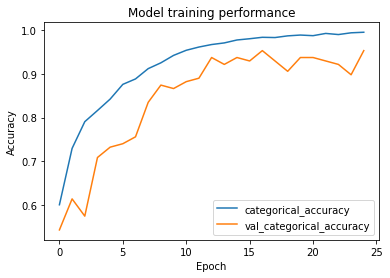

val_categorical_accuracy:  0.9527559280395508


In [46]:
plt.plot(history.history['categorical_accuracy'],label="categorical_accuracy")
plt.plot(history.history['val_categorical_accuracy'],label='val_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model training performance")
plt.legend()
plt.show()
val_acc = history.history['val_categorical_accuracy'][-1]
print("val_categorical_accuracy: ",val_acc)

1st convolution layer: 18 x 16


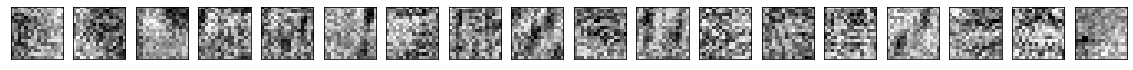

2nd convolution layer: 42 x 8


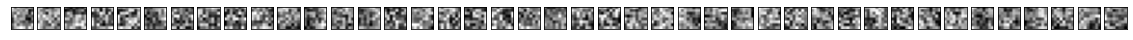

In [53]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

n_1 = optimised_params['filters_1']
print('1st convolution layer:',n_1,'x',optimised_params['kernel_size_1'])
fig, axs = plt.subplots(1,n_1, figsize=(20, 20))
axs = axs.ravel()
for i in range(n_1):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

n_2 = optimised_params['filters_2']
print('2nd convolution layer:',n_2,'x',optimised_params['kernel_size_2'])
fig, axs = plt.subplots(1,n_2, figsize=(20, 50))
axs = axs.ravel()
for i in range(n_2):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Evaluation

In [54]:
X_train = np.load('mels_BAD_PROPER_train.npz')['data']
y_train = np.load('mels_lables_BAD_PROPER_train.npz',allow_pickle=True)['data']
_,X_test,_,y_test,_,_ = format_for_CNN(X_train, X_test, y_train, y_test)

ValueError: Data must be 1-dimensional

In [55]:
print(X_test.shape)
print(y_test.shape)

(127, 128, 51, 1)
(127, 2)


In [56]:
predicted_prob = model.predict(X_test)
predictions = np.argmax(predicted_prob, axis=1)

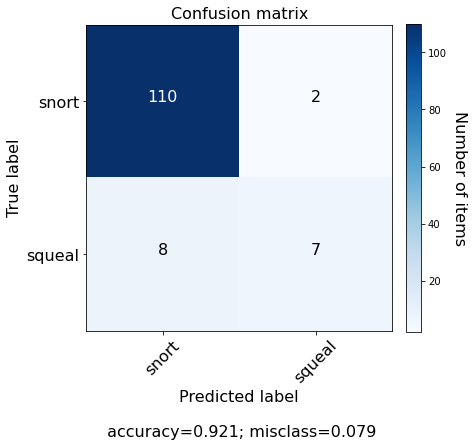

In [57]:
labels_list = np.unique(classes)
truths = np.argmax(y_test, axis=1)
cm = confusion_matrix(truths, predictions, labels=range(num_classes))
test_acc = plot_confusion_matrix(cm,labels_list,normalize=False,savefig = 'CM_CNN_OPT')

In [58]:
print(val_acc)
print(test_acc)

0.9527559280395508
0.9212598425196851
